# ECG Masking Strategies Visualization

This notebook visualizes the different masking strategies for ECG-JEPA:

1. **1D Temporal Masking (Standard)**: Same mask for all 12 leads (200 tokens)
2. **2D Random Block Masking**: Rectangular blocks in (12 leads × 200 time) space (2400 tokens)
3. **2D Lead Group Masking**: Clinically motivated groups at random time ranges
4. **🆕 Grouped Patches**: 4 groups × 200 time = **800 tokens** (NEW!)


In [16]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

sys.path.insert(0, os.getcwd())
from data.masks import MaskCollator, MaskCollator2D, MaskCollator2DLeadGroup, MaskCollatorGrouped

plt.rcParams['axes.grid'] = False
print("Modules loaded!")


Modules loaded!


In [17]:
# Configuration
PATCH_SIZE = 25
NUM_PATCHES = 200
CROP_SIZE = PATCH_SIZE * NUM_PATCHES
CHANNELS = 12

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
GROUPED_NAMES = ['Limb\n(I,II,III)', 'Augmented\n(aVR,aVL,aVF)', 'Septal\n(V1,V2,V3)', 'Lateral\n(V4,V5,V6)']

# Create synthetic ECG
ecg = torch.randn(CHANNELS, CROP_SIZE)
print(f"ECG shape: {ecg.shape}")


ECG shape: torch.Size([12, 5000])


In [18]:
# Create all collators
collator_1d = MaskCollator(patch_size=PATCH_SIZE, min_block_size=10, min_keep_ratio=0.15, max_keep_ratio=0.25)
collator_2d = MaskCollator2D(patch_size=PATCH_SIZE, num_leads=12, min_keep_ratio=0.15, max_keep_ratio=0.25)
collator_2d_group = MaskCollator2DLeadGroup(patch_size=PATCH_SIZE, num_leads=12, min_keep_ratio=0.15, max_keep_ratio=0.25)
collator_grouped_1d = MaskCollatorGrouped(patch_size=PATCH_SIZE, num_groups=4, mode='1d', min_block_size=10, min_keep_ratio=0.15, max_keep_ratio=0.25)
collator_grouped_2d = MaskCollatorGrouped(patch_size=PATCH_SIZE, num_groups=4, mode='2d', min_keep_ratio=0.15, max_keep_ratio=0.25)

# Generate masks
_, mask_1d_ctx, mask_1d_tgt = collator_1d([ecg])
_, (mask_2d_ctx, _), _ = collator_2d([ecg])
_, (mask_2d_group_ctx, _), _ = collator_2d_group([ecg])
_, mask_gr1d_ctx, _ = collator_grouped_1d([ecg])
_, (mask_gr2d_ctx, _), _ = collator_grouped_2d([ecg])

print("All masks generated!")


All masks generated!


In [19]:
# Visualization functions
def to_grid_1d(mask_ctx, num_rows, num_patches=200):
    grid = np.ones((num_rows, num_patches))
    for t in mask_ctx[0].numpy():
        grid[:, t] = 0
    return grid

def to_grid_2d(mask_ctx, num_rows, num_patches=200):
    grid = np.ones((num_rows, num_patches))
    for row, time in mask_ctx[0].numpy():
        if row < num_rows and time < num_patches:
            grid[row, time] = 0
    return grid

def plot_mask(grid, title, labels, height=5):
    fig, ax = plt.subplots(figsize=(16, height), dpi=100)
    cmap = ListedColormap(['#2E86AB', '#E94F37'])
    ax.imshow(grid, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Time Patch Index')
    ax.set_title(title, fontweight='bold')
    ctx_pct = (grid == 0).sum() / grid.size * 100
    ax.text(1.01, 0.5, f'Context: {ctx_pct:.1f}%', transform=ax.transAxes, va='center')
    legend = [mpatches.Patch(facecolor='#2E86AB', label='Context'), mpatches.Patch(facecolor='#E94F37', label='Target')]
    ax.legend(handles=legend, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.show()


## 1. Standard 1D Temporal Masking (200 tokens)
Same mask for all 12 leads - original ECG-JEPA approach.


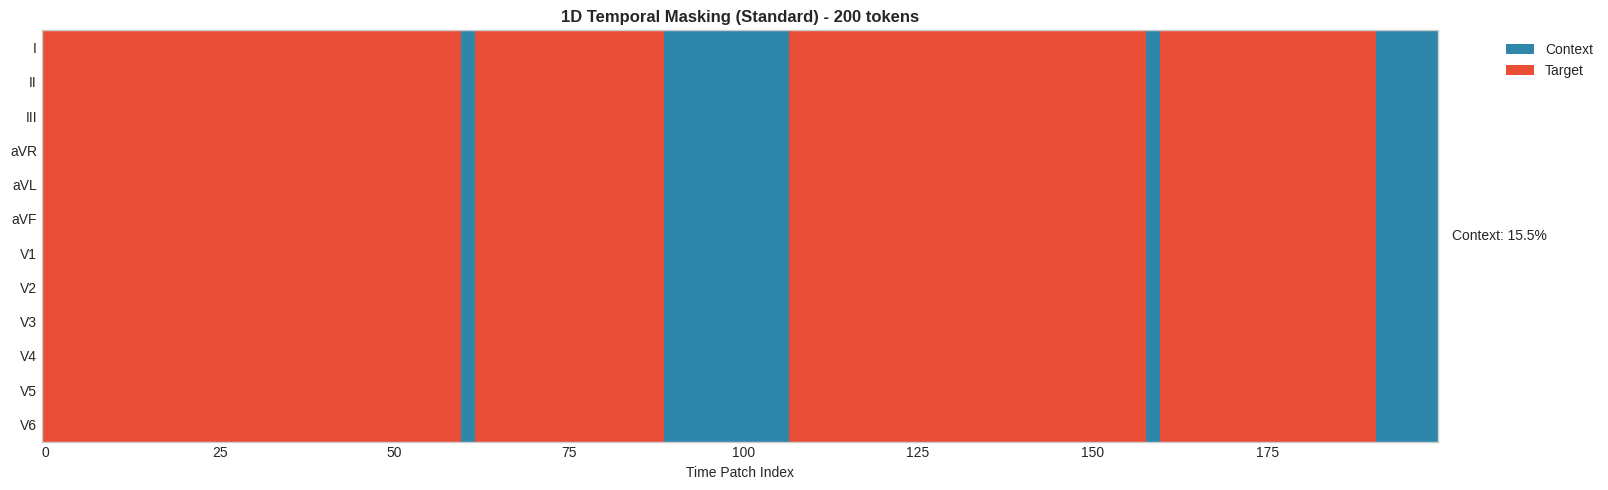

In [20]:
plot_mask(to_grid_1d(mask_1d_ctx, 12), '1D Temporal Masking (Standard) - 200 tokens', LEAD_NAMES)


## 2. 2D Random Block Masking (Factorized - 2400 tokens)
Different masks per lead - rectangular blocks in lead × time space.


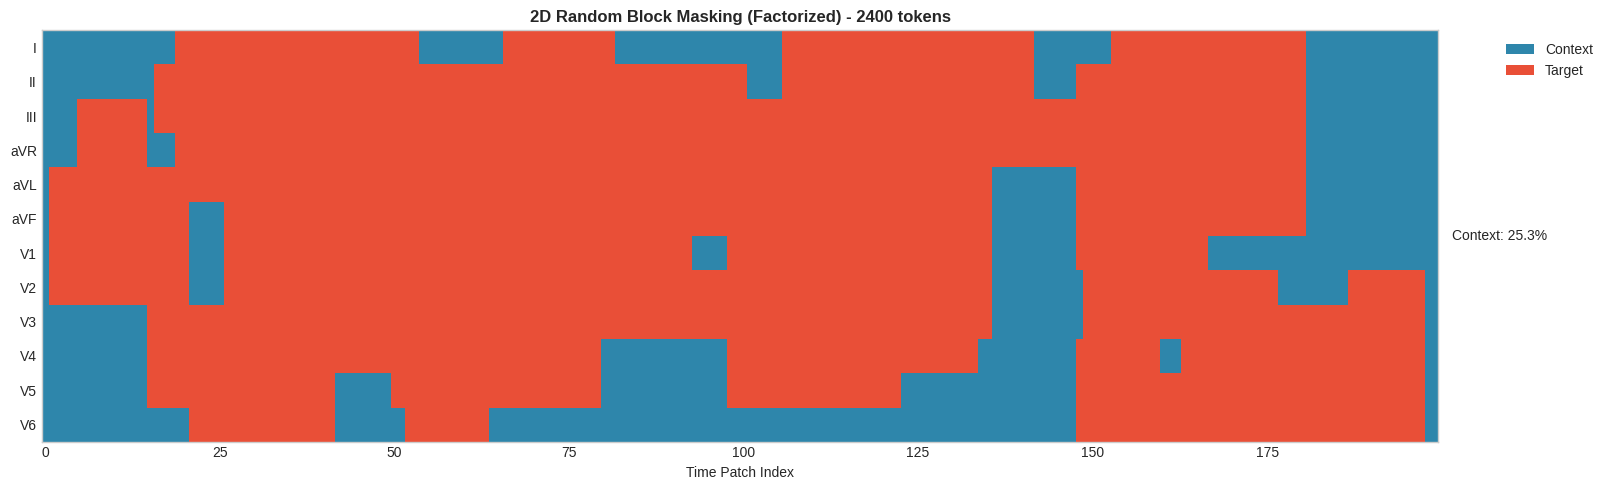

In [21]:
plot_mask(to_grid_2d(mask_2d_ctx, 12), '2D Random Block Masking (Factorized) - 2400 tokens', LEAD_NAMES)


## 3. 2D Lead Group Masking (Factorized - 2400 tokens)
Masks clinical lead groups (inferior, lateral, anterior, etc.)


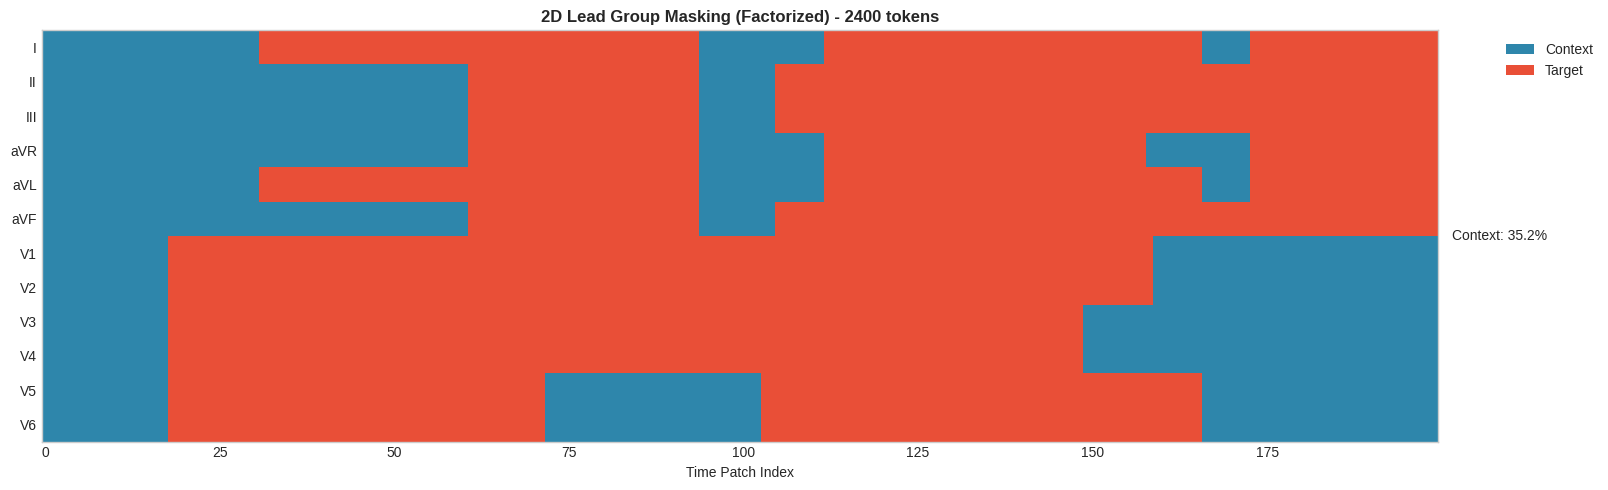

In [22]:
plot_mask(to_grid_2d(mask_2d_group_ctx, 12), '2D Lead Group Masking (Factorized) - 2400 tokens', LEAD_NAMES)


---

# 🆕 NEW: Grouped Architecture (800 tokens)

**Groups 3 leads together at the patch level:**

| Group | Leads | Clinical Meaning |
|-------|-------|------------------|
| **Group 0** | I, II, III | Limb leads (Einthoven triangle) |
| **Group 1** | aVR, aVL, aVF | Augmented leads |
| **Group 2** | V1, V2, V3 | Septal/Anterior precordial |
| **Group 3** | V4, V5, V6 | Lateral precordial |

**Benefits:**
- **3× fewer tokens** (800 vs 2400)
- **9× faster attention** (O(800²) vs O(2400²))
- **Forces early cross-lead learning** at the patch level


## 4. Grouped 1D Masking (800 tokens)
Same time mask for all 4 groups - simple and efficient.


/tmp/ipykernel_3531569/2857936948.py:27: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/yasser/miniconda3/envs/jepa-ecg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


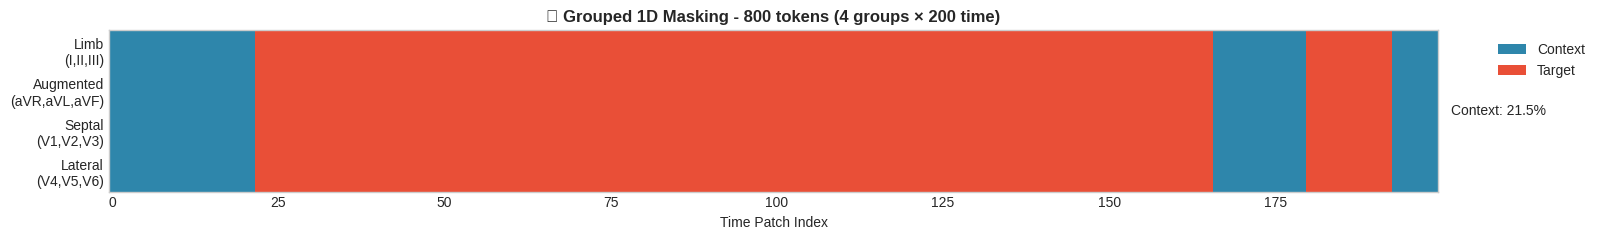

In [23]:
plot_mask(to_grid_1d(mask_gr1d_ctx, 4), '🆕 Grouped 1D Masking - 800 tokens (4 groups × 200 time)', GROUPED_NAMES, height=2.5)


## 5. Grouped 2D Masking (800 tokens)
Different masks per group - allows cross-group prediction tasks.


/tmp/ipykernel_3531569/2857936948.py:27: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/yasser/miniconda3/envs/jepa-ecg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


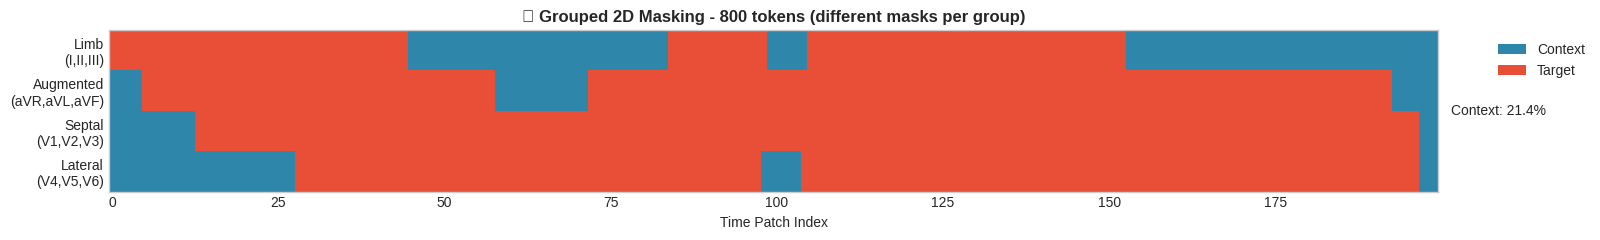

In [24]:
plot_mask(to_grid_2d(mask_gr2d_ctx, 4), '🆕 Grouped 2D Masking - 800 tokens (different masks per group)', GROUPED_NAMES, height=2.5)


---

## Summary: Architecture Comparison


In [25]:
print("="*80)
print("ARCHITECTURE COMPARISON")
print("="*80)
print(f"{'Architecture':<30} {'Tokens':<10} {'Attention Ops':<20} {'Config Setting'}")
print("-"*80)
print(f"{'Standard (original)':<30} {'200':<10} {'O(200²) = 40K':<20} structure: standard")
print(f"{'Factorized (12 leads)':<30} {'2400':<10} {'O(2400²) = 5.76M':<20} structure: factorized")
print(f"{'🆕 Grouped (4 groups)':<30} {'800':<10} {'O(800²) = 640K':<20} structure: grouped")
print("="*80)
print("\n🎯 Grouped is 9× faster than factorized while still learning cross-lead patterns!")


ARCHITECTURE COMPARISON
Architecture                   Tokens     Attention Ops        Config Setting
--------------------------------------------------------------------------------
Standard (original)            200        O(200²) = 40K        structure: standard
Factorized (12 leads)          2400       O(2400²) = 5.76M     structure: factorized
🆕 Grouped (4 groups)           800        O(800²) = 640K       structure: grouped

🎯 Grouped is 9× faster than factorized while still learning cross-lead patterns!
